In [40]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sc

# Trajectories from TEUFEL tracking

In [19]:
FileName = "/home/lehnertu/Programming/TEUFEL/csr2d_trajectory.hdf5"
hdf = h5py.File(FileName, "r")

In [20]:
hdf.keys()

<KeysViewHDF5 ['Trajectories']>

In [22]:
dataset = hdf['Trajectories']
dataset

<HDF5 dataset "Trajectories": shape (1001, 1, 6), type "<f8">

In [23]:
traj = np.array(dataset)[:,0,:]
traj.shape

(1001, 6)

In [24]:
hdf.close()

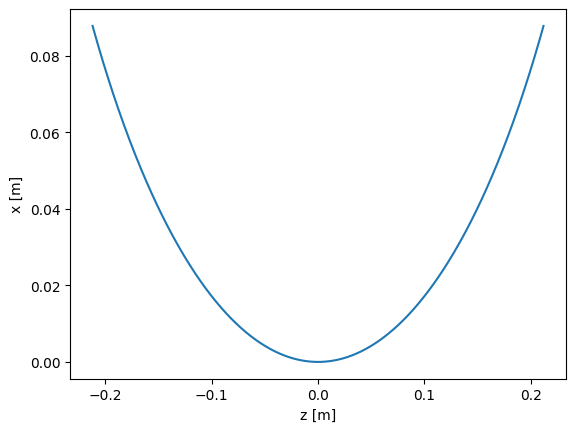

In [27]:
x = traj[:,0]
z = traj[:,2]

plt.plot(z,x)
plt.xlabel('z [m]')
plt.ylabel('x [m]')
plt.show()

In [30]:
traj[500]

array([ 2.92212919e-10,  0.00000000e+00, -1.22810846e-05, -4.00533919e-03,
        0.00000000e+00,  9.78424497e+01])

In [31]:
traj[501]

array([3.51073806e-07, 0.00000000e+00, 4.58933072e-04, 1.49677153e-01,
       0.00000000e+00, 9.78423353e+01])

In [49]:
X0 = traj[500,0:3]
X1 = traj[501,0:3]

In [36]:
BG0 = traj[500,3:]
BG1 = traj[501,3:]
BG = 0.5*(BG0+BG1)

In [46]:
Gamma = np.sqrt( np.dot(BG,BG) + 1.0)
print(Gamma)
Beta = BG/Gamma
print(Beta)

97.84752975239775
[7.44381660e-04 0.00000000e+00 9.99947498e-01]


In [45]:
R = 0.3
L = R*np.pi/2
t = L/sc.c
dt = t / 1000
print(f'dt = {dt:.6g} s')

dt = 1.57188e-12 s


In [51]:
print(X0+Beta*sc.c*dt)
print(X1)

[3.51073806e-07 0.00000000e+00 4.58933072e-04]
[3.51073806e-07 0.00000000e+00 4.58933072e-04]


# Snapshot from TEUFEL tracking

In [159]:
FileName = "/home/lehnertu/Programming/TEUFEL/csr2d_snap_501.h5"

# open the file
hdf = h5py.File(FileName, "r")
print(hdf)
print(hdf.keys())
# Get the groups
pos_group = hdf['ObservationPosition']
Nx = pos_group.attrs.get('Nx')
Ny = pos_group.attrs.get('Ny')
print(pos_group)
print("Nx=%d Ny=%d" % (Nx,Ny))
field_group = hdf['ElMagField']
print(field_group)
par_group = hdf['ParticleCoordinates']
N_par = par_group.attrs.get('N_particles')
print(par_group)
print("Npart=%d" % N_par)
# get the data
pos = np.array(pos_group)
A = np.array(field_group)
coo = np.array(par_group)
hdf.close()

<HDF5 file "csr2d_snap_501.h5" (mode r)>
<KeysViewHDF5 ['ElMagField', 'ObservationPosition', 'ParticleCoordinates']>
<HDF5 dataset "ObservationPosition": shape (101, 251, 3), type "<f8">
Nx=101 Ny=251
<HDF5 dataset "ElMagField": shape (101, 251, 6), type "<f8">
<HDF5 dataset "ParticleCoordinates": shape (1, 6), type "<f8">
Npart=1


In [160]:
Ex = A[:,:,0]
Ey = A[:,:,1]
Ez = A[:,:,2]
Bx = A[:,:,3]
By = A[:,:,4]
Bz = A[:,:,5]

In [161]:
x_part = coo[:,0]
z_part = coo[:,2]
print(x_part)
print(z_part)

[3.51073806e-07]
[0.00045893]


In [162]:
print(pos.shape)
x = pos[:,:,0]
print(np.min(x), np.max(x))
z = pos[:,:,2]
print(np.min(z), np.max(z))

(101, 251, 3)
-0.0025 0.0025
-0.000625 0.000625


365288165124.634


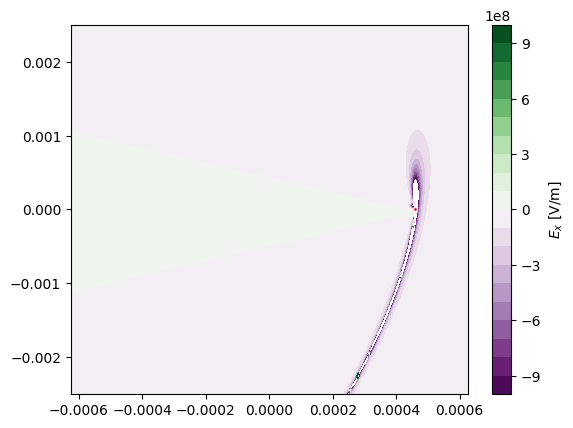

In [163]:
emax = np.max(np.abs(Ex))
print(emax)
emax = 1e9
elevels = np.linspace(-emax, emax, num=21)

img = plt.contourf(z,x,Ex,elevels,cmap='PRGn')
cbar = plt.colorbar(img)
cbar.set_label('$E_x$ [V/m]')
plt.scatter(z_part,x_part,c='r',s=1)
plt.show()

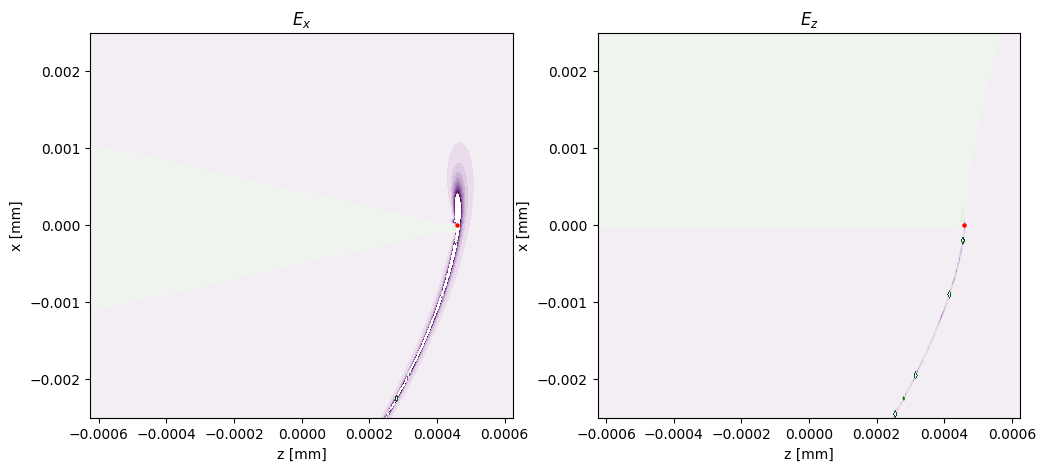

In [164]:
emax = 1e9
elevels = np.linspace(-emax, emax, num=21)

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
ax1.contourf(z,x,Ex,elevels,cmap='PRGn')
ax1.set_xlabel('z [mm]')
ax1.set_ylabel('x [mm]')
ax1.scatter(z_part,x_part,c='r',s=5)
ax1.set_title('$E_x$')
ax2.contourf(z,x,Ez,elevels,cmap='PRGn')
ax2.set_xlabel('z [mm]')
ax2.set_ylabel('x [mm]')
ax2.scatter(z_part,x_part,c='r',s=5)
ax2.set_title('$E_z$')
plt.show()